In [1]:
%matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from brokenaxes import brokenaxes
from enum import Enum
import argparse
import os
import json

import seaborn as sns

from paper import *

PLAIN_COLOR = "#4285F4"
INCREMENTAL_COLOR = '#DB4437'
COMMIT_COLOR = "#F4B400"
from enum import IntFlag

class Mode(IntFlag):
    OUT_OF_ORDER = 0
    IN_ORDER = 1
    COMMIT = 2
    INCREMENTAL = 4

In [2]:

palette_colors = [[.22, .52, .71], [.53, .80, .81],
                  [144 / 255., 12 / 255, 63 / 255.],
                  [67 / 255., 135 / 255., 107 / 255.],
                  [248 / 255., 194 / 255., 145 / 255.]]
sns.set_palette(palette_colors)

matplotlib.rc('font', family='serif', size=9)
matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=8)
matplotlib.rc('figure', figsize=(2.5, 1.4))
matplotlib.rc('axes', linewidth=0.5)
matplotlib.rc('lines', linewidth=0.5)

adjust_settings()

<ipython-input-2-98e1559fe72f>:8: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])
/Users/leonhards/projects/tuplex-public/benchmarks/incremental/notebooks/paper.py:36: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])


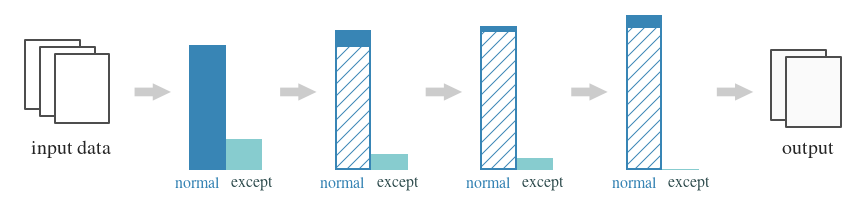

In [196]:
# generate from these the plot
e_pct = np.array([.2, .1, .08, 0.005])

# calc normal from e_pct
n_pct = [0] * len(e_pct)
n_pct[0] = 1.0 - e_pct[0]
n_last_pct = [0] * len(n_pct)

for i in range(1, len(e_pct)):
    n_pct[i] = n_pct[i-1] + e_pct[i-1] - e_pct[i]
    n_last_pct[i] = n_pct[i - 1]
e_pct, n_pct

xq = list(range(2 * len(n_pct)))
for i in range(0, len(xq), 2):
    xq[i] *= 2
    xq[i + 1] = xq[i] + 1
xq

plt.figure(figsize=(15,3))
lw= 2
factor = 9
plt.bar(np.array(xq[::2])-.5, (np.array(n_pct) - np.array(n_last_pct)) * factor, 
        bottom = np.array(n_last_pct) * factor,
        width=1, ec='none', linewidth=lw)
patches = plt.bar(np.array(xq[::2])-.5, np.array(n_last_pct) * factor, width=1, color='none',
        ec=sns.color_palette()[0], hatch='//', linewidth=2 * lw)


plt.bar(np.array(xq[1::2]) -.5, np.array(e_pct) * factor, width=1, color=sns.color_palette()[1],
        ec='none', linewidth=lw)
# plt.bar(np.array(xq[::2])-.5, np.array(n_last_pct) * 10, width=1)

for bar in patches:
    bar.set_clip_path(bar.get_path(), bar.get_transform())

# xq = [0, 1, 4, 5]
# yq = [10, 4, 12, 3]
# plt.bar(xq, yq)

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

paths = [Rectangle((-5.5 + 0.4 * i, 3.5 - 0.4 * i), 1.5, 4) for i in range(3)]
pc = PatchCollection(paths, facecolor='white', edgecolor=[.3]*3)
ax = plt.gca()
ax.add_collection(pc)
plt.text(-4.25, 1.24, 'input data', ha='center', va='center', size=20)

# #plt.text(5.25, 0.05, savings_label, ha="center", va="center", size=20, bbox=dict(facecolor='white', alpha=1.0))
for i in range(len(n_pct) + 1):
    plt.arrow(1.5 + 4 * i - 4, 4.5, 1, 0, length_includes_head=True, width=0.5,
              head_width=1, head_length=.5, edgecolor='none', facecolor=[0.8]*3)
    
    if i != len(n_pct):
        darken_factor=.4
        plt.text(i * 4 - .15, -1, 'normal', ha='right', size=16,
                 color=np.array(sns.color_palette()[0]))
        plt.text(i * 4 + .15, -1, 'except', ha='left', size=16,
                 color=np.array(sns.color_palette()[1]) * darken_factor)
        
paths = [Rectangle((max(xq) + 2 + 0.4 * i, 3.5 - 0.4 * i - .6), 1.5, 4) for i in range(2)]
pc = PatchCollection(paths, edgecolor=[.3]*3, facecolor=[.98]*3)
ax = plt.gca()
ax.add_collection(pc)
plt.text(max(xq) + 3 , 1.24, 'output', ha='center', va='center', size=20)
        
plt.axis('off')
plt.grid(False)
plt.xlim(-6, max(xq) + 4)
sns.despine()
plt.savefig(os.path.join('plots', 'design-overview.pdf'),
            transparent=True, dpi=120, bbox_inches = 'tight', pad_inches = 0)